# Scallop Theorem

In this notebook we will make slender rods and dip them in highly viscous fluids. In doing so we will observe Purcell's Scallop Theorem in action.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid")
from mpl_toolkits.mplot3d import axes3d
from itertools import product
plt.rcParams["animation.html"] = "jshtml"
from celluloid import Camera

In [2]:
figfile = "figs/"

Create a mesh to model movements in a fluid.

In [3]:
def mesher(scale = np.arange(-1, 1, 0.1)):
    x = y = z = scale
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    R = np.array([X,Y,Z])
    return R

In [4]:
R = mesher() #creates the grid

Define positions of motor (rotlet) and the rod (stokeslet) elements.

In [5]:
def initialize(Ns=100,L=0.1):
    #number of elements and length of rod
    s = np.zeros([Ns,3]); s[:,0] = np.arange(0,L+L/Ns,L/(Ns-1)) #rod elements
    r = np.array([0]) #which rod elements have motors
    return s,r

Define the rotlet and stokeslet velocity vectors at a point p.

In [6]:
def rotlet(R,tau,p,e):
    #x-x0
    R = np.array([R[i]-p[i] for i in range(3)]) 
    
    #distance squared
    r2 = np.sum(R**2,axis=0) 
    
    #scaling
    const = ((2*r2)+(5*(e**2)))/(16*np.pi*((r2+(e**2))**(5/2)))  
    
    #vector field
    U = const*np.cross(tau,R,axis=0) 
    return U

In [7]:
def stokeslet(R,f,p,e):
    #x-x0
    R = np.array([R[i]-p[i] for i in range(3)])
    
    #distance squared
    r2 = np.sum(R**2,axis=0)
    
    #forces at each point in the grid
    F = np.array([(0*R[i])+f[i] for i in range(3)])
    
    #constants for scaling
    const_1 = ((r2)+(2*(e**2)))
    const_2 = (8*np.pi*((r2+(e**2))**(3/2)))
    
    #dot product
    dot = np.sum([f[i]*R[i] for i in range(3)],axis=0)
    
    #velocity field
    U = ((dot*R) + (F*const_1))/const_2
    return U

Define the velocity interpolator to find velocity at an arbitrary point p not on the grid.

In [8]:
def Up(U,p,R):
    V = np.array(np.shape(U))
    V = [sp.interpolate.RegularGridInterpolator((R[0][:,0,0], R[1][0,:,0], R[2][0,0,:]), U[i]) for i in range(3)]
    Vp = np.array([V[i](p)[0] for i in range(3)])
    return Vp

Define a function to find the force between two rod elements.

In [9]:
def hookes(s,i,j,k,l0):
    #force acting on j due to i
    f = (k*(np.linalg.norm(s[j]-s[i])-l0)/(l0*(np.linalg.norm(s[j]-s[i]))))*(-(s[j]-s[i]))
    return f

Define a function to evolve the system in time given a time varying torque.

In [10]:
def evolve (tau,tim,R,r,s,k,e):
    dt = tim[1]-tim[0]
    l0 = np.zeros(np.shape(s)[0]-1)
    for joint,_ in enumerate(l0):
        l0[joint] = np.linalg.norm(s[joint+1]-s[joint])
    
    #initialize
    Ust = np.zeros(np.shape(R))
    
    #velocity field for each instant in time
    U = np.zeros((tim.size,)+np.shape(R))
    
    #position of rod elements for each instant in time
    rod = np.zeros((tim.size,)+np.shape(s))
    
    for i,t in enumerate(tim):
        #reset
        Urot = np.zeros(np.shape(R))
        
        #get velocities due to torques
        for m,mot in enumerate(r):
            Urot += rotlet(R,tau[m][i],s[mot],e)
        
        #get velocity field for time instant
        U[i] = Urot+Ust

        #get positions of rod elements due to flow
        for si in range(s.shape[0]):
            s[si] += (Up(U[i],s[si],R)*dt) #euler's method
            
        rod[i] = s
        
        #reset
        Ust = np.zeros(np.shape(R))
        
        #get forces due to elements on their neighbours
        for si in range(s.shape[0]-1):
            f = hookes(s,si,si+1,k,l0[si])
            Ust += stokeslet(R,f,s[si+1],e)+stokeslet(R,-f,s[si],e)
        
    return U,rod

## Setup

We need to create a movement pattern for our object. To do this we need to specify a torque varying in time for each of our motors. For this simple case, we have one motor placed initially at the origin and the torque will be given by $\tau = [0,0,q(t)]$.

In [11]:
dt = 0.01
T = 8
tim = np.arange(0,T,dt)

In [12]:
tau = np.array([np.zeros(np.shape(tim)+(3,))])

In [13]:
power = 0.4
strokes = 4
tau[0,:,-1] = power
step = (tim<0)
for i in np.arange(T/8, T, 2*T/strokes):
       step = step|((tim>=i)&(tim<=i+T/strokes))
tau[0,step,-1] = -power

Let's plot $q(t)$ vs. time ($t$).

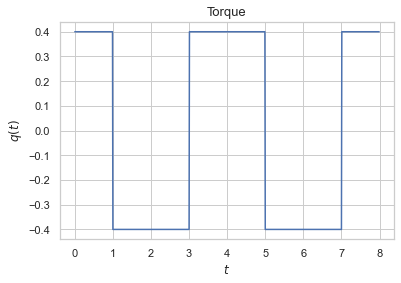

In [14]:
plt.figure()
plt.plot(tim,tau[0,:,-1])
plt.xlabel('$t$')
plt.ylabel('$q(t)$')
plt.title("Torque", fontsize = 13)
plt.show()

# Flapping Rods 

Let's compare a rigid rod and a bendy rod to see which one shows net translation. The rigid rod and bendy rod will be simulated seperately but artificially overlapped onto to the same graph for comparison. The graph shows the top view of the 3D space.

In [15]:
s,r = initialize(Ns=100,L=0.1)
_,rod_ben = evolve(tau,tim,R,r,s,k=100,e=0.3)

s,r = initialize(Ns=2,L=0.1)
_,rod_rig = evolve(tau,tim,R,r,s,k=300,e=0.3)

In [16]:
fig = plt.figure(figsize = (4.5,4.5))
plt.xlim(-0.1,0.2); plt.ylim(-0.15,0.15)
camera = Camera(fig)
for i in range(0,np.shape(rod_rig)[0],10):
    
    plt.plot(rod_rig[i].T[0],rod_rig[i].T[1]+0.05,'k-', linewidth=2, alpha=0.5, label='_nolegend_')
    plt.plot(rod_rig[i].T[0][0],rod_rig[i].T[1][0]+0.05,'r.')
    
    plt.plot(rod_ben[i].T[0],rod_ben[i].T[1]-0.05,'k-', linewidth=2, alpha=0.5, label='_nolegend_')
    plt.plot(rod_ben[i].T[0][0],rod_ben[i].T[1][0]-0.05,'b.')
    
    camera.snap()
plt.legend(['stiff','bendy'])
plt.close()

In [17]:
animation = camera.animate()
animation.save(figfile+"scallop_theorem.gif",writer = 'imagemagick',fps = 10,dpi=300)
animation

The bendy rod translates over time, but the rigid rod remains in the same position. Notice that the direction of movement of the bendy rod is difficult to arrive at intuitively.